# Machine Learning Pipeline and Ablation

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gdal
import osr
import rasterio
from rasterio.plot import show
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

In [115]:
X_train_df = pd.read_pickle('generated/data_pkl/X_train.pkl')
X_test_df = pd.read_pickle('generated/data_pkl/X_test.pkl')
y_train = pd.read_pickle('generated/data_pkl/y_train.pkl')
y_test = pd.read_pickle('generated/data_pkl/y_test.pkl')

df_data = pd.read_pickle('generated/data_pkl/df_data.pkl')
block_cv = pd.read_pickle('generated/data_pkl/block_cv.pkl')

### Feature selection

Used for ablation studies

Select which features to keep when training the model below before running the rest of the pipeline.

In [116]:
X_train_df.columns

Index(['protected', 'qflag', 'lc_0.0', 'lc_1.0', 'lc_2.0', 'lc_12.0',
       'lc_15.0', 'lc_16.0', 'lc_18.0', 'lc_20.0', 'lc_21.0', 'lc_23.0',
       'lc_24.0', 'lc_25.0', 'lc_26.0', 'lc_27.0', 'lc_29.0', 'lc_30.0',
       'lc_31.0', 'lc_32.0', 'lc_34.0', 'slope', 'dem', 'emi', 'lst', 'ndvi',
       'evi', 'vi', 'ampl', 'minv', 'maxv', 'rslope', 'lslope', 'dist_2',
       'dist_3', 'dist_4', 'fire_count'],
      dtype='object')

In [117]:
X_train_df.describe()

,protected,qflag,lc_0.0,lc_1.0,lc_2.0,lc_12.0,lc_15.0,lc_16.0,lc_18.0,lc_20.0,...,vi,ampl,minv,maxv,rslope,lslope,dist_2,dist_3,dist_4,fire_count
count,1.069996e+06,1.069996e+06,1069996.0,1069996.0,1069996.0,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,...,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06
mean,3.313096e-03,9.169856e+00,0.0,0.0,0.0,1.696184e-01,7.364514e-04,1.785053e-04,1.478192e-01,1.509959e-01,...,1.306744e-01,5.156181e-01,5.518547e-02,5.647145e-01,2.803369e-01,3.311040e-01,4.068858e-01,4.520499e-01,4.083157e-01,7.205167e-03
std,5.746410e-02,1.486245e+00,0.0,0.0,0.0,3.752974e-01,2.712766e-02,1.335940e-02,3.549209e-01,3.580450e-01,...,2.114534e-01,2.454077e-01,6.282085e-02,2.554495e-01,8.060924e-02,1.389069e-01,2.086991e-01,2.203635e-01,2.082007e-01,5.423613e-02
min,0.000000e+00,1.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,9.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.101770e-02,3.491000e-01,9.856832e-03,3.988667e-01,2.288089e-01,2.147413e-01,2.473209e-01,2.745630e-01,2.491442e-01,0.000000e+00
50%,0.000000e+00,1.000000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.109510e-02,5.339667e-01,3.211903e-02,5.895667e-01,2.598338e-01,3.075833e-01,3.935011e-01,4.417518e-01,3.949738e-01,0.000000e+00
75%,0.000000e+00,1.000000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.117829e-02,6.989000e-01,7.934188e-02,7.572667e-01,3.063712e-01,4.273565e-01,5.342851e-01,6.251549e-01,5.354002e-01,0.000000e+00
max,1.000000e+00,1.000000e+01,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


LightGBM supports categorical data, so one-hot encoding is not needed anymore.

In [118]:
lc_features = ['lc_0.0', 'lc_1.0', 'lc_2.0', 'lc_12.0', 'lc_15.0',
       'lc_16.0', 'lc_18.0', 'lc_20.0', 'lc_21.0', 'lc_23.0', 'lc_24.0',
       'lc_25.0', 'lc_26.0', 'lc_27.0', 'lc_29.0', 'lc_30.0', 'lc_31.0',
       'lc_32.0', 'lc_34.0']

In [119]:
land_cover = []
for idx, row in X_train_df.iterrows():
    for lci in lc_features:
        if row[lci] == 1.0:
            val = lci.split('_')[1]
            land_cover.append(val)
            break
assert(len(land_cover) == len(X_train))

In [120]:
land_cover_test = []
for idx, row in X_test_df.iterrows():
    for lci in lc_features:
        if row[lci] == 1.0:
            val = lci.split('_')[1]
            land_cover_test.append(val)
            break
assert(len(land_cover_test) == len(X_test))

In [121]:
X_train_df.loc[:, 'land_cover'] = land_cover
X_test_df.loc[:, 'land_cover'] = land_cover_test

In [122]:
features = ['protected', 'ndvi', 'slope', 'dem', 'land_cover']

In [123]:
# Update train, test files accordingly
X_train = X_train_df[features]
X_test = X_test_df[features]

In [124]:
X_train['land_cover'] = X_train['land_cover'].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
X_train.describe()

,protected,ndvi,slope,dem
count,1.069996e+06,1.069996e+06,1.069996e+06,1.069996e+06
mean,3.313096e-03,5.989560e-01,9.595248e-01,2.050936e-01
std,5.746410e-02,1.927802e-01,5.981521e-02,1.909766e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.710390e-01,9.440000e-01,7.189745e-02
50%,0.000000e+00,6.682502e-01,9.880000e-01,1.247447e-01
75%,0.000000e+00,7.233219e-01,1.000000e+00,2.858474e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Models

##### Scoring

In [126]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, fbeta_score, confusion_matrix
from sklearn.metrics import classification_report

In [127]:
def make_classification_report(y_test, y_predict, threshold = 0, f=None):
    y_pred = y_predict
    if (threshold != 0):
        y_pred = [1 if (x >= threshold) else 0 for x in y_predict]
    return f"""
    Precision: {precision_score(y_test, y_pred)}\n
    Recall: {recall_score(y_test, y_pred)}\n
    F1-score: {f1_score(y_test, y_pred)}\n
    Accuracy: {accuracy_score(y_test, y_pred)}\n
    Classification Report : \n
    {classification_report(y_test, y_pred, target_names=['Not burnt', 'Burnt'])}\n
    """
    # f1-score is the harmonic mean between precision and recall

#### LightGBM

In [128]:
# Setup cross validation
def cv(k=5):
    return ((train, test) for train, test in StratifiedGroupKFold(n_splits=k).split(X_train, y_train, groups=block_cv))

##### Grid Search

In [129]:
#cv_data = cv()

In [ ]:
# import lightgbm as lgb
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.model_selection import GridSearchCV

# Set the hyperparameters to tune
# parameters = {
# 	'n_estimators': [200],
# 	'max_depth': [2, 4, 7, 12],
#    'num_leaves': [4, 16, 31], 
# 	'class_weight': ['balanced']
# }

# fit_params = {'categorical_feature':['land_cover']}

# # Initialize the model
# model = lgb.LGBMClassifier()

# # Initialize the grid search object
# grid_search = GridSearchCV(model, parameters, scoring='f1', cv=cv_data, return_train_score=True, verbose=10)

# # Fit the model to the data
# grid_search.fit(X_train, y_train, **fit_params)

# # Get the best set of hyperparameters
# best_params = grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 1/5; 1/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4;, score=(train=0.404, test=0.312) total time= 1.3min
[CV 2/5; 1/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 2/5; 1/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4;, score=(train=0.417, test=0.282) total time= 1.3min
[CV 3/5; 1/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 3/5; 1/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4;, score=(train=0.394, test=0.441) total time= 1.3min
[CV 4/5; 1/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 4/5; 1/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4;, score=(train=0.335, test=0.448) total time= 1.3min
[CV 5/5; 1/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 5/5; 1/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=4;, score=(train=0.399, test=0.311) total time= 1.3min
[CV 1/5; 2/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 1/5; 2/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16;, score=(train=0.404, test=0.312) total time= 1.3min
[CV 2/5; 2/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 2/5; 2/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16;, score=(train=0.417, test=0.282) total time= 1.3min
[CV 3/5; 2/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 3/5; 2/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16;, score=(train=0.394, test=0.441) total time= 1.3min
[CV 4/5; 2/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 4/5; 2/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16;, score=(train=0.335, test=0.448) total time= 1.3min
[CV 5/5; 2/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 5/5; 2/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=16;, score=(train=0.399, test=0.311) total time= 1.3min
[CV 1/5; 3/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 1/5; 3/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31;, score=(train=0.404, test=0.312) total time= 1.3min
[CV 2/5; 3/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 2/5; 3/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31;, score=(train=0.417, test=0.282) total time= 1.3min
[CV 3/5; 3/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 3/5; 3/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31;, score=(train=0.394, test=0.441) total time= 1.3min
[CV 4/5; 3/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 4/5; 3/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31;, score=(train=0.335, test=0.448) total time= 1.3min
[CV 5/5; 3/12] START class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 5/5; 3/12] END class_weight=balanced, max_depth=2, n_estimators=200, num_leaves=31;, score=(train=0.399, test=0.311) total time= 1.3min
[CV 1/5; 4/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 1/5; 4/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4;, score=(train=0.414, test=0.318) total time= 1.5min
[CV 2/5; 4/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 2/5; 4/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4;, score=(train=0.424, test=0.286) total time= 1.5min
[CV 3/5; 4/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 3/5; 4/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4;, score=(train=0.404, test=0.445) total time= 1.5min
[CV 4/5; 4/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 4/5; 4/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4;, score=(train=0.344, test=0.452) total time= 1.5min
[CV 5/5; 4/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 5/5; 4/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=4;, score=(train=0.411, test=0.321) total time= 1.5min
[CV 1/5; 5/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 1/5; 5/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16;, score=(train=0.440, test=0.324) total time= 4.3min
[CV 2/5; 5/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 2/5; 5/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16;, score=(train=0.443, test=0.286) total time= 4.3min
[CV 3/5; 5/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 3/5; 5/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16;, score=(train=0.420, test=0.451) total time= 4.3min
[CV 4/5; 5/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 4/5; 5/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16;, score=(train=0.368, test=0.463) total time= 4.3min
[CV 5/5; 5/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 5/5; 5/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=16;, score=(train=0.433, test=0.335) total time= 4.2min
[CV 1/5; 6/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 1/5; 6/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31;, score=(train=0.440, test=0.324) total time= 4.3min
[CV 2/5; 6/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 2/5; 6/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31;, score=(train=0.443, test=0.286) total time= 4.1min
[CV 3/5; 6/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 3/5; 6/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31;, score=(train=0.420, test=0.451) total time= 3.3min
[CV 4/5; 6/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 4/5; 6/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31;, score=(train=0.368, test=0.463) total time= 3.4min
[CV 5/5; 6/12] START class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31


Using categorical_feature in Dataset.


[CV 5/5; 6/12] END class_weight=balanced, max_depth=4, n_estimators=200, num_leaves=31;, score=(train=0.433, test=0.335) total time= 4.2min
[CV 1/5; 7/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 1/5; 7/12] END class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4;, score=(train=0.414, test=0.318) total time= 1.4min
[CV 2/5; 7/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 2/5; 7/12] END class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4;, score=(train=0.424, test=0.286) total time= 1.3min
[CV 3/5; 7/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 3/5; 7/12] END class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4;, score=(train=0.404, test=0.445) total time= 1.3min
[CV 4/5; 7/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 4/5; 7/12] END class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4;, score=(train=0.344, test=0.452) total time= 1.3min
[CV 5/5; 7/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4


Using categorical_feature in Dataset.


[CV 5/5; 7/12] END class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=4;, score=(train=0.411, test=0.321) total time= 1.3min
[CV 1/5; 8/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


[CV 1/5; 8/12] END class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=16;, score=(train=0.450, test=0.333) total time= 4.6min
[CV 2/5; 8/12] START class_weight=balanced, max_depth=7, n_estimators=200, num_leaves=16


Using categorical_feature in Dataset.


**Calibration**  
Probability calibration is the process of adjusting the predicted probabilities output by a machine learning model such that they accurately reflect the true underlying probabilities of the classes. In other words, it involves adjusting the model's predictions so that they are more closely aligned with the actual outcomes of the events being predicted.

There are two main types of probability calibration: Platt scaling and isotonic regression. Platt scaling, also known as sigmoid calibration, involves fitting a sigmoid curve to the predicted probabilities output by the model, in order to adjust them to be more accurate. Isotonic regression involves fitting a step function to the predicted probabilities, such that the probabilities are monotonically increasing.

In [ ]:
# cv_data = cv()

# # Initialize the calibrated model with the best set of hyperparameters
# calibrated_model = CalibratedClassifierCV(
# 	base_estimator=lgb.LGBMClassifier(**best_params),
# 	cv=cv_data
# )

# # Fit the calibrated model to the data
# calibrated_model.fit(X_train, y_train)

In [ ]:
# y_predict_train = calibrated_model.predict(X_train)
# y_predict_test = calibrated_model.predict(X_test)

In [ ]:
# # Save the results to a txt file
# with open('results/results_lgbm_f1.txt', 'w') as f:
# 	f.write(f'Best set of hyperparameters: {best_params}\n')
# 	f.write(f'Train score: {make_classification_report(y_train, y_predict_train)}\n')
# 	f.write(f'Test score: {make_classification_report(y_test, y_predict_test)}\n')

In [28]:
best_params_ = {'max_depth': 15, 'n_estimators': 100, 'class_weight': 'balanced'}

In [30]:
cv_data = cv()

base_estimator = lgb.LGBMClassifier(**best_params_)

# Initialize the calibrated model with the best set of hyperparameters
calibrated_model = CalibratedClassifierCV(
	lgb.LGBMClassifier(**best_params_),
	cv=cv_data
)

# Fit the calibrated model to the data
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=<generator object cv.<locals>.<genexpr> at 0x7f01427c9040>,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                max_depth=15))

In [31]:
y_predict_train = calibrated_model.predict(X_train)
y_predict_test = calibrated_model.predict(X_test)

In [32]:
# Save the results to a txt file
with open('results/results_lgbm_f1_.txt', 'w') as f:
	f.write(f'Best set of hyperparameters: {best_params_}\n')
	f.write(f'Train report: {make_classification_report(y_train, y_predict_train)}\n')
	f.write(f'Test report: {make_classification_report(y_test, y_predict_test)}\n')

In [49]:
model = calibrated_model

In [34]:
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay

def plot_metrics(y_test, y_pred_proba, y_predict):
    #define metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)

    f, axs = plt.subplots(1, 2, figsize=(15,5))

    #create ROC curve
    axs[0].plot(fpr, tpr, label="AUC="+str(auc))
    axs[0].plot(lr_precision, lr_recall, label="Precision/Recall")
    axs[0].set_ylabel('True Positive Rate/Precision')
    axs[0].set_xlabel('False Positive Rate/Recall')
    axs[0].legend(loc=4)

    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axs[1], colorbar=False)
    _ = disp.ax_.set_title("Calibrated Random Forest")
    plt.show()
    return fpr, tpr, thresholds

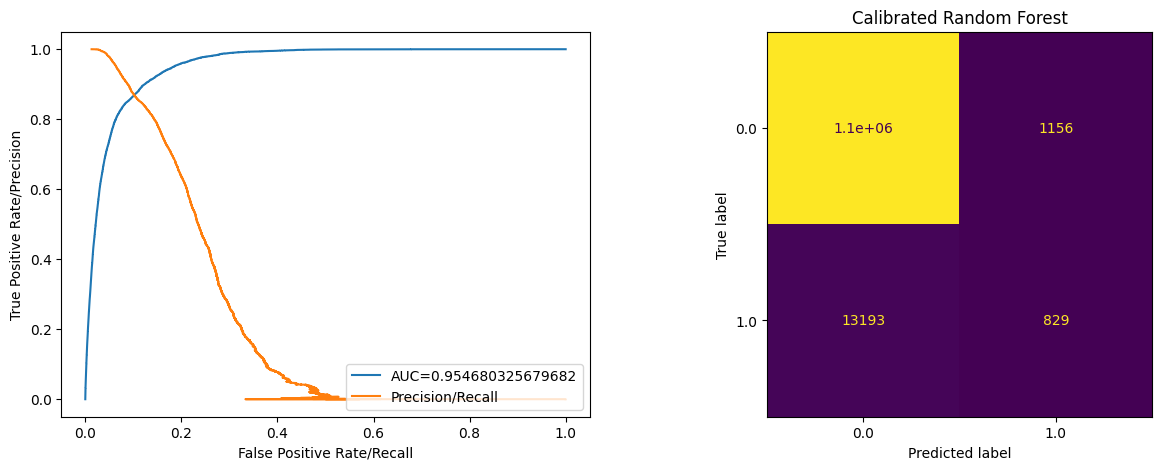

In [35]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = plot_metrics(y_test, y_pred_proba, y_predict_test)

In [36]:
# optimal threshold for the classifier 
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

print(make_classification_report(y_test, y_pred_proba, optimal_threshold))

Threshold value is: 0.17511335676813994

    Precision: 0.08632393090817486

    Recall: 0.9042219369562117

    F1-score: 0.15760197390909822

    Accuracy: 0.8733194198195605

    Classification Report : 

                  precision    recall  f1-score   support

   Not burnt       1.00      0.87      0.93   1055921
       Burnt       0.09      0.90      0.16     14022

    accuracy                           0.87   1069943
   macro avg       0.54      0.89      0.54   1069943
weighted avg       0.99      0.87      0.92   1069943


    


#### Susceptibility map

In [37]:
def create_susceptibility_map(filename, y_pred_proba):
    ds = gdal.Open('data_preprocessing/data_final/protected/raster_natural_protected.tif')
    band = ds.GetRasterBand(1)
    ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    wkt = ds.GetProjection()


    # Create gtif file
    driver = gdal.GetDriverByName("GTiff")
    output_file = "output/"+filename+".tif"

    y_pred_rescaled = pd.Series(np.zeros(len(df_data)))
    y_pred_rescaled[X_test.index] = y_pred_proba
    array_rf = np.reshape(y_pred_rescaled.values, (1156, 1943))

    dst_ds = driver.Create(output_file,
                           band.XSize,
                           band.YSize,
                           1,
                           gdal.GDT_Float32)

    #writing output raster
    dst_ds.GetRasterBand(1).WriteArray( array_rf )

    #setting nodata value
    dst_ds.GetRasterBand(1).SetNoDataValue(0)

    #setting extension of output raster
    dst_ds.SetGeoTransform(geotransform)

    # setting spatial reference of output raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection( srs.ExportToWkt() )

    #Close output raster dataset
    ds = None
    dst_ds = None

In [38]:
create_susceptibility_map('susceptibility_rf', y_pred_proba)

<AxesSubplot: title={'center': 'Susceptibility Map 2022 using Random Forest'}>

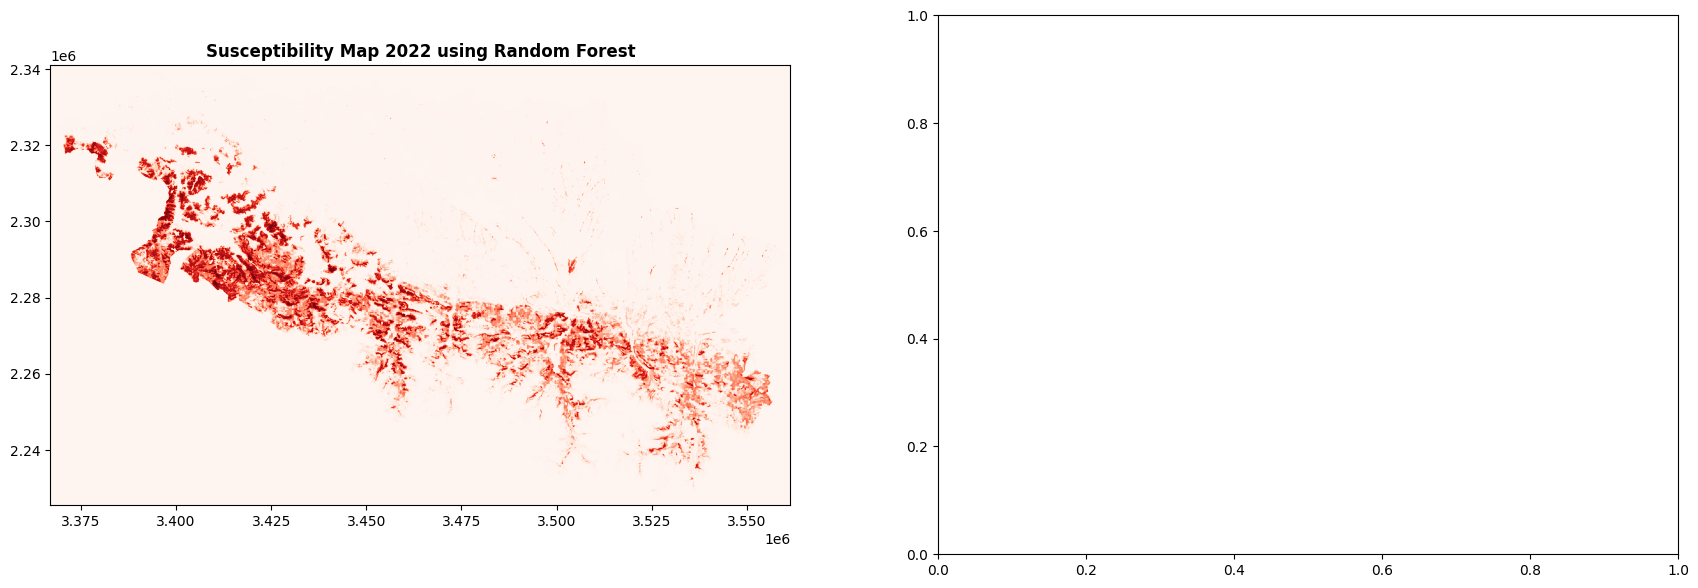

In [39]:
susceptibility_rf = rasterio.open('output/susceptibility_rf.tif')
array_r = susceptibility_rf.read(1).flatten()

fig, axs = plt.subplots(1, 2, figsize=(21,7))
show((susceptibility_rf, 1), ax=axs[0], cmap='Reds', title = 'Susceptibility Map 2022 using Random Forest')

In [40]:
show((fireyear_raster['2022'], 1), cmap='Reds', ax=axs[1], title = 'Fire Map 2022')

NameError: name 'fireyear_raster' is not defined

(array([11632., 10863., 10680., 10297., 11683., 13252., 14397., 13229.,
         8821.,  6177.,  4778.,  3838.,  3352.,  3615.,  4230.,  5761.,
         7414.,  6715.,  6287.,  6998.,  7715., 10982.,  7617.,  3625.,
         1306.]),
 array([0.10000221, 0.11675318, 0.13350414, 0.1502551 , 0.16700607,
        0.18375703, 0.200508  , 0.21725896, 0.23400992, 0.25076089,
        0.26751185, 0.28426282, 0.30101378, 0.31776474, 0.33451571,
        0.35126667, 0.36801764, 0.3847686 , 0.40151956, 0.41827053,
        0.43502149, 0.45177246, 0.46852342, 0.48527438, 0.50202535,
        0.51877631]),
 <BarContainer object of 25 artists>)

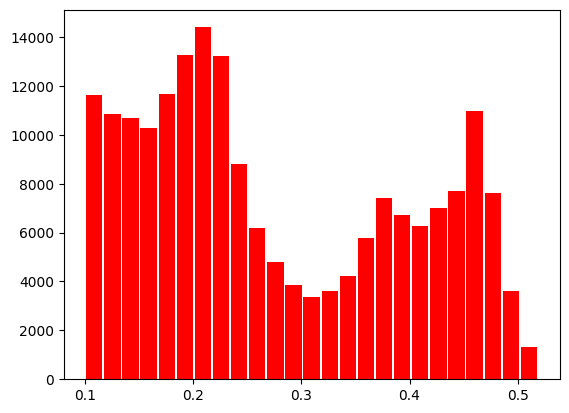

In [41]:
plt.hist(y_pred_proba[y_pred_proba > 0.1], bins=25, rwidth=0.9, color='red')

### Explainability

**Pre-calibration LightGBM feature importance** 

In [ ]:
legend_column = {'lc_12.0': 'Empty', 'lc_15.0': 'Artificial surfaces', 'lc_16.0': 'Wetlands', 'lc_18.0': 'Non-irrigated arable land', 'lc_20.0': 'Vineyards', 'lc_21.0': 'Fruit trees and berry plantations', 'lc_23.0': 'Pastures', 'lc_24.0': 'Complex cultivation patterns', 'lc_25.0': 'Land principally occupied by agriculture with significant areas of natural vegetation', 'lc_26.0': 'Broad-leaved forest', 'lc_27.0': 'Coniferous forest', 'lc_29.0': 'Mixed forest'}

In [60]:
# Pre-calibrated model
lgbm_best = model.estimator.fit(X_train, y_train)

# Pre-calibration model
booster = lgbm_best.booster_
feature_imp = pd.DataFrame({'Value': booster.feature_importance(), 'Feature': [legend_column[s] if ('lc' in s) else s for s in list(X_train.columns)]})

plt.figure(figsize=(32, 11))
sn.set(font_scale = 2)
sn.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.savefig('output/lgbm_importances-01.png')
plt.show()

KeyboardInterrupt: 

**SHAP values**

In [56]:
shap.initjs()
# using calibrated classifier base estimator
sample_test = shap.sample(X_test, 100) 
sample_test = sample_test.reset_index().drop(columns = ['index'])
sample_test.columns = [legend_column[s] if ('lc' in s) else s for s in list(sample_test.columns)]

size = len(sample_test)
explainer = shap.TreeExplainer(lgbm_best)
shap_values = explainer.shap_values(sample_test)
shap.force_plot(explainer.expected_value[1], shap_values[1][:size,:], sample_test.iloc[:size,:])

NameError: name 'legend_column' is not defined

In [57]:
shap.summary_plot(shap_values, sample_test)

NameError: name 'shap_values' is not defined